In [4]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras.optimizers import adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
K.set_image_dim_ordering('tf')

Define weighted f1 and balanced accuarcy

In [3]:
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

Read data and split validation set

In [5]:
def load_dataset_with_processing(input_train_test_fn, num_classes = 10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']
    
    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
    
    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)
    
    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)
    
    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)
    
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return X_train, y_train, X_vali, y_vali, X_test, y_test

Build a data generator

In [7]:
def myGenerator(X_train, y_train, batch_size):    
    total_size = X_train.shape[0]
    
    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]
                    
            yield X_batch, y_batch

Build the lenet model with pretrained weights

In [8]:
def build_model(input_shape, num_classes):
    # initialize the model
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
    
    for layer in model.layers:
        layer.trainable = False  # freeze the previous layers
    
    X = model.output
    # softmax classifier
    predictions = Dense(10, activation='softmax')(X)
    old_model = Model(inputs=model.input, outputs=predictions)
    
    # load weights
    old_model.load_weights('./pretrained_mnist/lenet.hdf5')

    X = model.output
    # softmax classifier
    predictions = Dense(num_classes, activation='softmax')(X)
    new_model = Model(inputs=model.input, outputs=predictions)

    new_model.summary()
    
    return new_model
    
input_shape = (28, 28, 1)
num_classes = 10
model = build_model(input_shape, num_classes)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_

Define the training function

In [12]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_model(input_shape, num_classes)
    
    checkpoint = ModelCheckpoint(checkpoint_dir + 'best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

    
    #Compile Keras Model 
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    datagen = myGenerator(X_train, y_train, batch_size)
    
    history = model.fit_generator(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[es, checkpoint],
                        verbose=2,
                        validation_data=(X_vali, y_vali))
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    return model

Define the testing function

In [10]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_model(input_shape, num_classes)

    # Compile Keras Model 
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    # load weights
    model.load_weights(pretrained_weights)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    
    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)
    
    return score[1], f1_score, balanced_accuracy_score  # return accuracies

Now we train the LeNet model

(395688, 28, 28, 1)
(98922, 28, 28, 1)
(107158, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_4 (

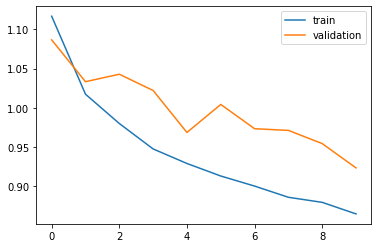

In [11]:
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = adam(lr=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './LeNet_MNIST_MIX/'
input_train_test_fn = './data/MNIST_MIX_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes = 100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

Then we test the saved model

In [13]:
pretrained_weights = './LeNet_MNIST_MIX/best.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_8 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 50)          0         
__________

D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
